In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random


from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


============================================================
## 01. Data Understanding
============================================================

In [2]:
# PATH dataset
BASE_DIR = os.getcwd()
DATASET_PATH = os.path.join(BASE_DIR, "Dataset", "Intel Image Classification")

TRAIN_DIR = os.path.join(DATASET_PATH, "seg_train")
TEST_DIR = os.path.join(DATASET_PATH, "seg_test")

In [6]:
# List kelas
classes = sorted(os.listdir(TRAIN_DIR))

print("=== Daftar Kelas ===")
print(*classes, sep=", ")

# Hitung jumlah gambar per kelas
train_count = {c: len(os.listdir(os.path.join(TRAIN_DIR, c))) for c in classes}
test_count  = {c: len(os.listdir(os.path.join(TEST_DIR, c))) for c in classes}

total_train = sum(train_count.values())
total_test  = sum(test_count.values())

print("\n=== Jumlah Gambar Train per Kelas ===")
for k, v in train_count.items():
    print(f"{k:<10} : {v}")
print(f"Total Train = {total_train}")

print("\n=== Jumlah Gambar Test per Kelas ===")
for k, v in test_count.items():
    print(f"{k:<10} : {v}")
print(f"Total Test = {total_test}")


=== Daftar Kelas ===
buildings, forest, glacier, mountain, sea, street

=== Jumlah Gambar Train per Kelas ===
buildings  : 2191
forest     : 2271
glacier    : 2404
mountain   : 2512
sea        : 2274
street     : 2382
Total Train = 14034

=== Jumlah Gambar Test per Kelas ===
buildings  : 437
forest     : 474
glacier    : 553
mountain   : 525
sea        : 510
street     : 501
Total Test = 3000


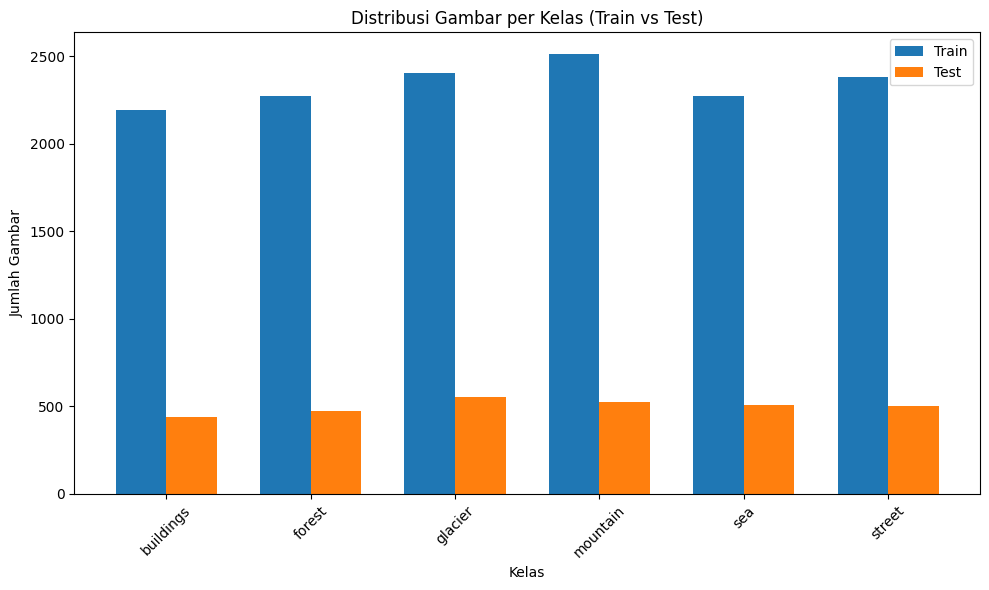

In [7]:
# Data plotting
labels = classes
train_vals = [train_count[c] for c in classes]
test_vals = [test_count[c] for c in classes]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, train_vals, width, label='Train')
plt.bar(x + width/2, test_vals, width, label='Test')

plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.title("Distribusi Gambar per Kelas (Train vs Test)")
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


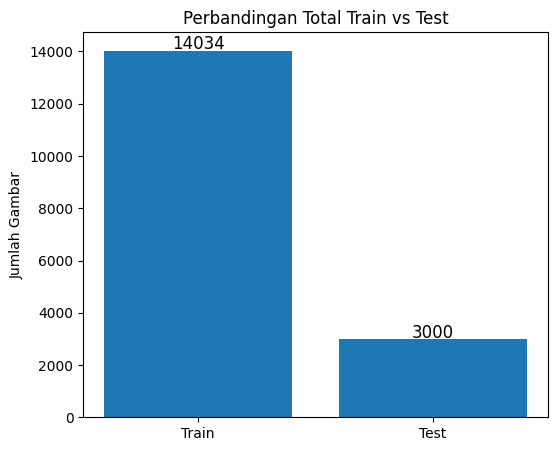

In [8]:
plt.figure(figsize=(6,5))
plt.bar(["Train", "Test"], [total_train, total_test])
plt.ylabel("Jumlah Gambar")
plt.title("Perbandingan Total Train vs Test")

for i, v in enumerate([total_train, total_test]):
    plt.text(i, v + 50, str(v), ha='center', fontsize=12)

plt.show()


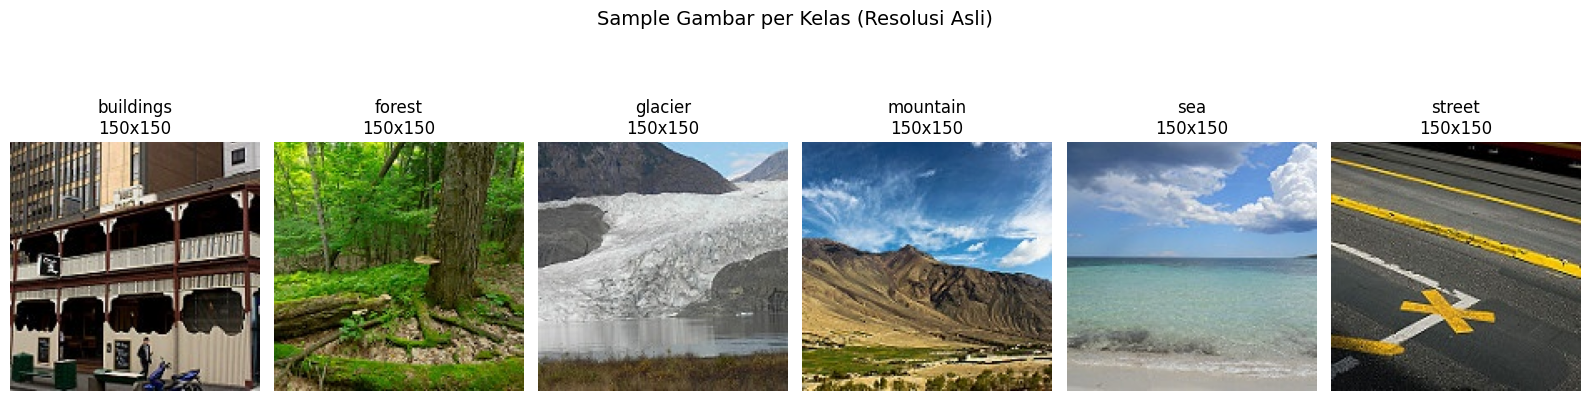

In [9]:
fig, axes = plt.subplots(1, len(classes), figsize=(16, 5))

for idx, cls in enumerate(classes):
    cls_dir = os.path.join(TRAIN_DIR, cls)
    sample_img = random.choice(os.listdir(cls_dir))
    img_path = os.path.join(cls_dir, sample_img)
    
    img = Image.open(img_path)
    
    axes[idx].imshow(img)
    axes[idx].set_title(f"{cls}\n{img.size[0]}x{img.size[1]}")
    axes[idx].axis('off')

plt.suptitle("Sample Gambar per Kelas (Resolusi Asli)", fontsize=14)
plt.tight_layout()
plt.show()


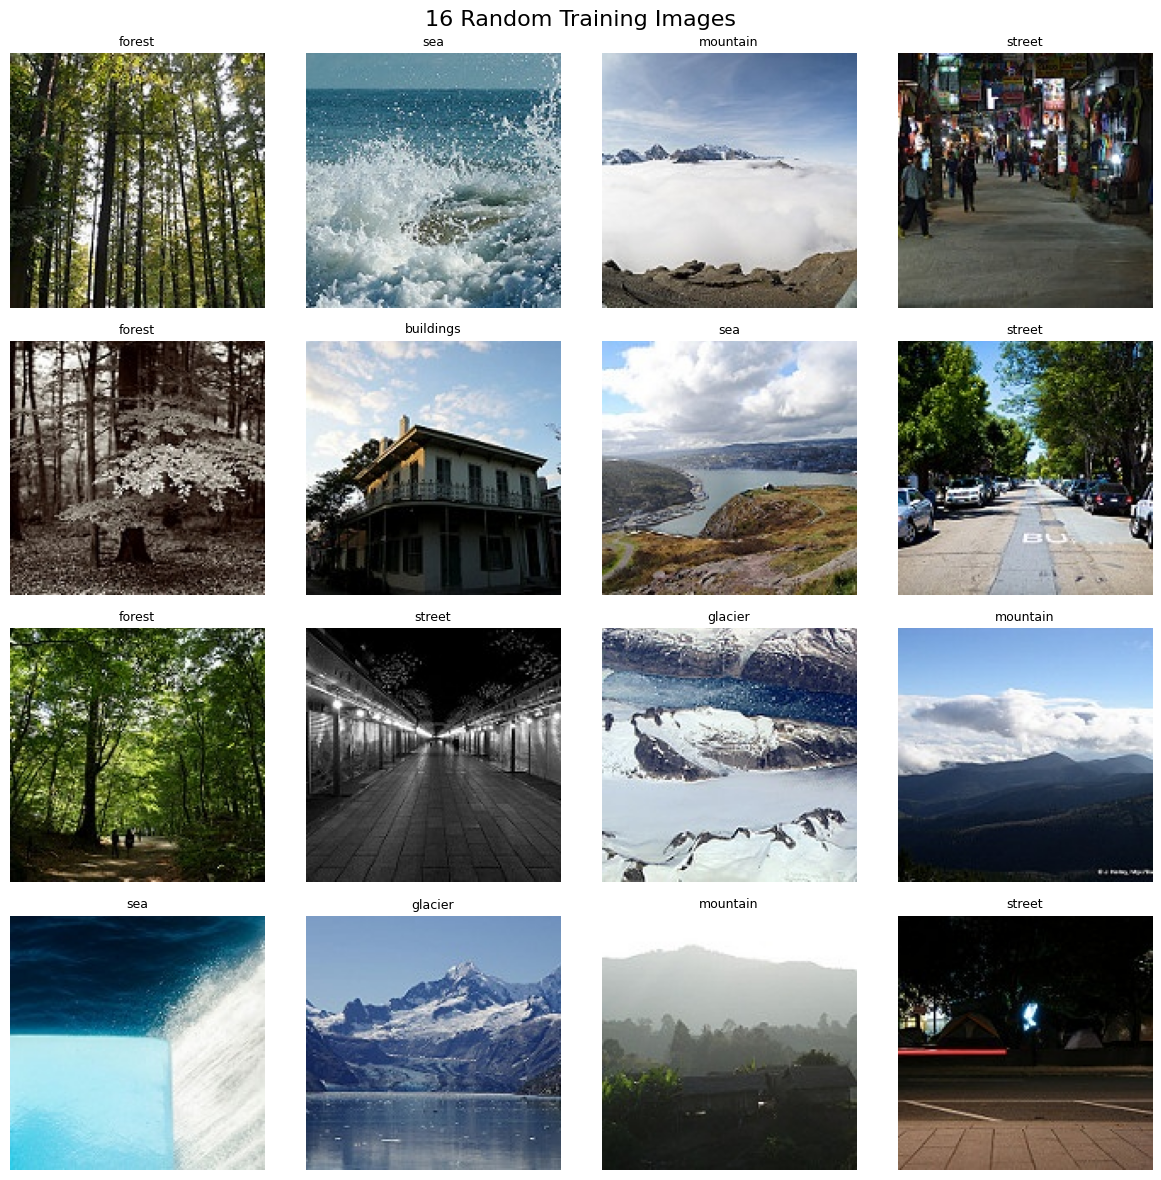

In [10]:
all_images = []
for cls in classes:
    folder = os.path.join(TRAIN_DIR, cls)
    all_images += [os.path.join(folder, f) for f in os.listdir(folder)]

sample_images = random.sample(all_images, 16)

plt.figure(figsize=(12, 12))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    label = img_path.split(os.sep)[-2]

    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.title(label, fontsize=9)
    plt.axis("off")

plt.suptitle("16 Random Training Images", fontsize=16)
plt.tight_layout()
plt.show()


============================================================
## 02. PREPROCESSING & AUGMENTATION
============================================================

In [11]:
# Transform untuk TRAIN (dengan augmentasi)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),

    transforms.ToTensor(),

    # Normalisasi standar ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Transform untuk TEST (tanpa augmentasi)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),

    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [12]:
# Load dataset
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
test_dataset  = datasets.ImageFolder(TEST_DIR,  transform=test_transform)


In [13]:
# DataLoader
batch_size = 32

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=4,
                         pin_memory=True)

print("Jumlah batch train:", len(train_loader))
print("Jumlah batch test :", len(test_loader))

# Cek 1 batch
images, labels = next(iter(train_loader))
print("Batch image shape:", images.shape)
print("Batch labels shape:", labels.shape)

Jumlah batch train: 439
Jumlah batch test : 94
Batch image shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32])


============================================================
## 03. MODEL: RESNET18 + ADAM OPTIMIZER
============================================================

In [14]:
num_classes = len(classes)

# Load pretrained model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze pretrained layer (opsional: kalau mau fine-tuning full, hapus blok ini)
for param in model.parameters():
    param.requires_grad = True   # jika mau freeze → False

# Replace fully-connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

============================================================
04. OPTIMIZER, LOSS, CALLBACKS
============================================================

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Scheduler mirip ReduceLROnPlateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

d:\CODE\Dicoding\2. Belajar Fundamental Deep Learning\Proyek Klasifikasi Gambar_Christian Daniel\.venv\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [16]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter}/{self.patience}")

            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [17]:
best_model_path = "best_resnet18_model.pth"
best_val_loss = float("inf")

============================================================
## 05. TRAINING LOOP
============================================================

In [18]:
epochs = 30
early_stopping = EarlyStopping(patience=5)

train_losses = []
val_losses = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 60)

    # ---------------------------- TRAIN ----------------------------
    model.train()
    train_loss = 0

    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)

    for imgs, labels in train_loader_tqdm:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # update progress bar
        train_loader_tqdm.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---------------------------- VALIDATION ----------------------------
    model.eval()
    val_loss = 0

    val_loader_tqdm = tqdm(test_loader, desc="Validating", leave=False)

    with torch.no_grad():
        for imgs, labels in val_loader_tqdm:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            val_loader_tqdm.set_postfix({"val_batch_loss": f"{loss.item():.4f}"})

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    # PRINT SUMMARY PER EPOCH
    print(f"Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f}")

    # ---------------------------- CALLBACKS ----------------------------
    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Model improved → Saved to {best_model_path}")

    early_stopping(avg_val_loss)

    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

print("\nTraining selesai!")



Epoch 1/30
------------------------------------------------------------


Train Loss = 0.3159 | Val Loss = 0.2109
Model improved → Saved to best_resnet18_model.pth

Epoch 2/30
------------------------------------------------------------


Train Loss = 0.2065 | Val Loss = 0.1957
Model improved → Saved to best_resnet18_model.pth

Epoch 3/30
------------------------------------------------------------


Train Loss = 0.1727 | Val Loss = 0.2023
EarlyStopping counter: 1/5

Epoch 4/30
------------------------------------------------------------


Train Loss = 0.1411 | Val Loss = 0.2253
EarlyStopping counter: 2/5

Epoch 5/30
------------------------------------------------------------


Train Loss = 0.1176 | Val Loss = 0.2266
EarlyStopping counter: 3/5

Epoch 6/30
------------------------------------------------------------


Train Loss = 0.1045 | Val Loss = 0.2366
EarlyStopping counter: 4/5

Epoch 7/30
------------------------------------------------------------


Train Loss = 0.0670 | Val Loss = 0.2084
EarlyStopping counter: 5/5
Early stopping triggered!

Training selesai!


============================================================
## 06. MODEL EVALUATION
============================================================


=== Classification Report ===
              precision    recall  f1-score   support

   buildings     0.9500    0.9130    0.9312       437
      forest     0.9812    0.9895    0.9853       474
     glacier     0.8818    0.8770    0.8794       553
    mountain     0.8990    0.8648    0.8816       525
         sea     0.9471    0.9824    0.9644       510
      street     0.9247    0.9561    0.9401       501

    accuracy                         0.9290      3000
   macro avg     0.9306    0.9305    0.9303      3000
weighted avg     0.9287    0.9290    0.9286      3000



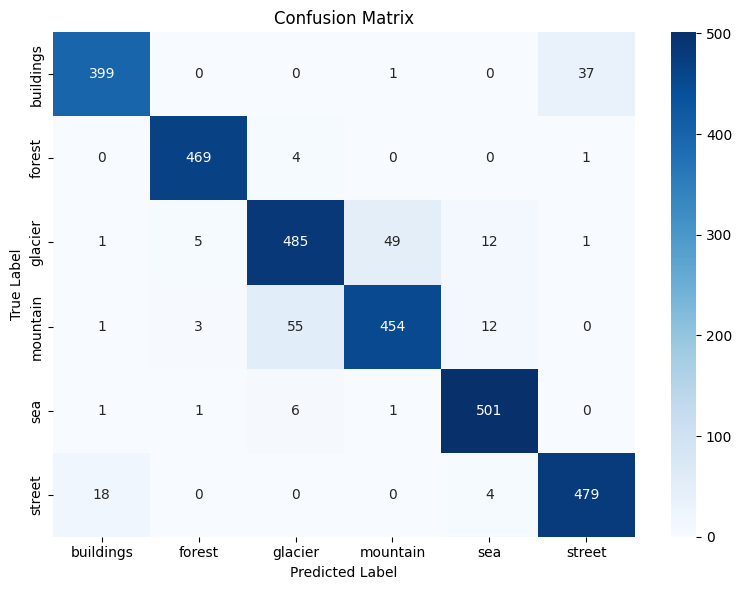


=== FINAL TEST METRICS ===
Final Test Precision : 0.9287
Final Test Recall    : 0.9290
Final Test F1 Score  : 0.9286
Final Test Accuracy  : 0.9290


In [23]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score, precision_recall_fscore_support, precision_score

# Load best model
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report (per-class + avg)
print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=classes, digits=4))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Final test metrics (recommended: weighted)
accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
final_precision = precision_score(all_labels, all_preds, average='weighted')
final_recall    = recall_score(all_labels, all_preds, average='weighted')
final_f1        = f1_score(all_labels, all_preds, average='weighted')


print("\n=== FINAL TEST METRICS ===")
print(f"Final Test Precision : {final_precision:.4f}")
print(f"Final Test Recall    : {final_recall:.4f}")
print(f"Final Test F1 Score  : {final_f1:.4f}")
print(f"Final Test Accuracy  : {accuracy:.4f}")

# ============================================
# 08. VISUALISASI BAR PER-CLASS METRICS
# ============================================

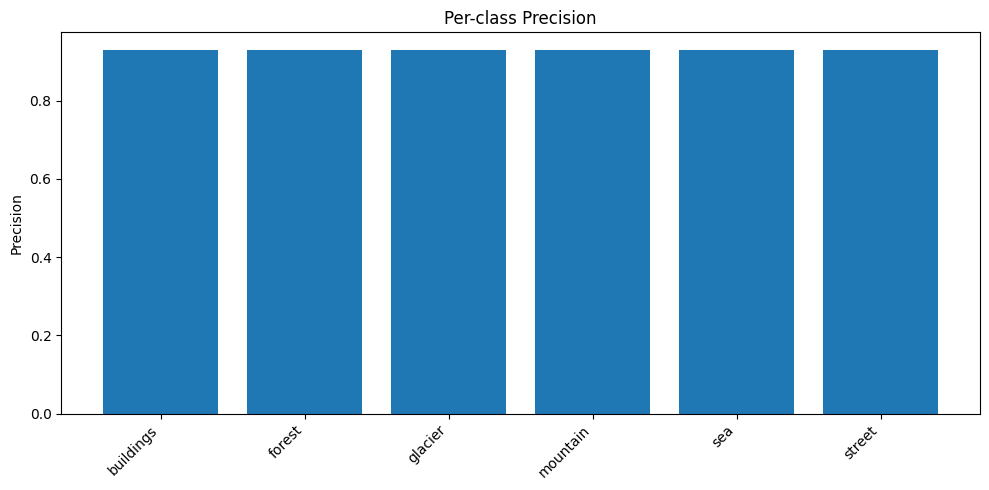

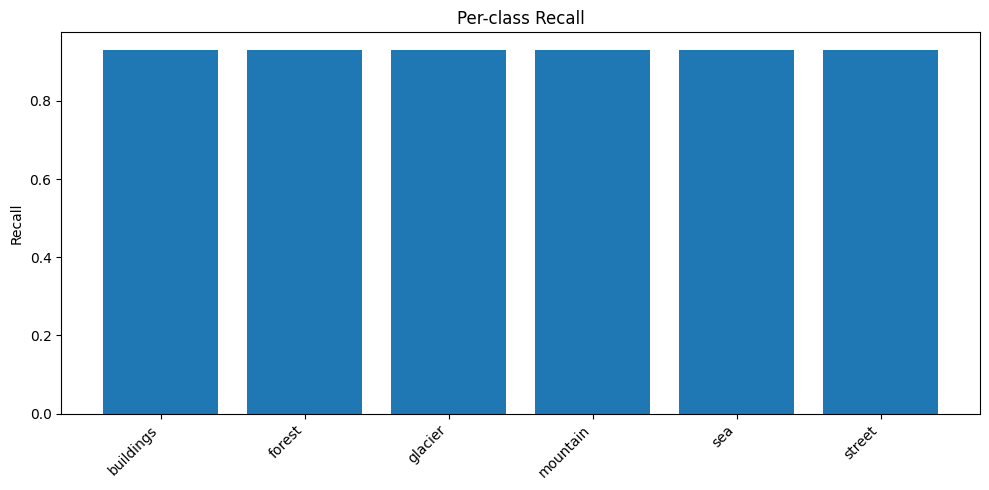

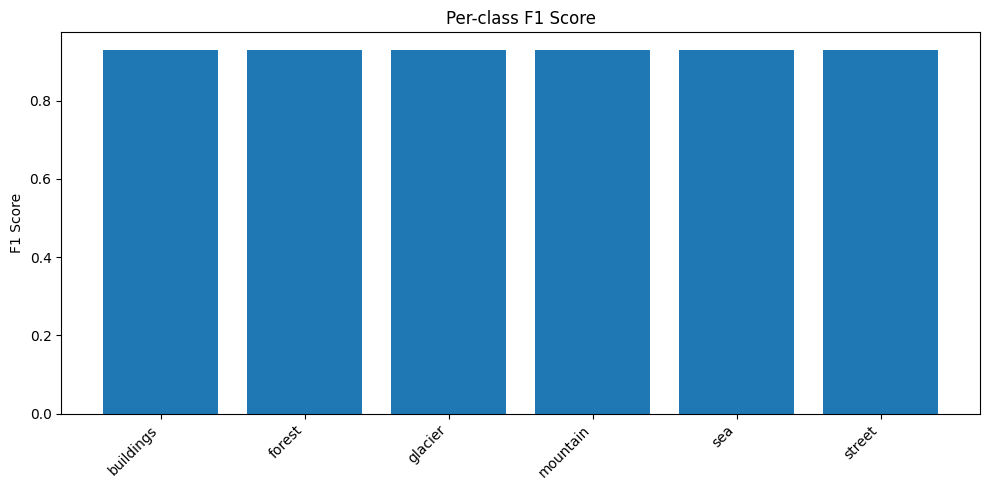

In [26]:
# Pastikan classes, precision, recall, f1 sudah ada dari perhitungan sebelumnya
x = np.arange(len(classes))

# ---------------- Precision ----------------
plt.figure(figsize=(10, 5))
plt.bar(x, final_precision)
plt.xticks(x, classes, rotation=45, ha='right')
plt.ylabel("Precision")
plt.title("Per-class Precision")
plt.tight_layout()
plt.show()

# ---------------- Recall ----------------
plt.figure(figsize=(10, 5))
plt.bar(x, final_recall)
plt.xticks(x, classes, rotation=45, ha='right')
plt.ylabel("Recall")
plt.title("Per-class Recall")
plt.tight_layout()
plt.show()

# ---------------- F1 Score ----------------
plt.figure(figsize=(10, 5))
plt.bar(x, final_f1)
plt.xticks(x, classes, rotation=45, ha='right')
plt.ylabel("F1 Score")
plt.title("Per-class F1 Score")
plt.tight_layout()
plt.show()

============================================================
## 07. SAVE MODEL (TorchScript + ONNX)
============================================================

In [28]:
SAVE_DIR = "saved_models_TORCH"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1. SAVE STATE_DICT (.pth)
pth_path = os.path.join(SAVE_DIR, "resnet18_state_dict.pth")
torch.save(model.state_dict(), pth_path)
print(f"Saved → {pth_path}")

# 2. TorchScript (.pt)
scripted_model_path = os.path.join(SAVE_DIR, "resnet18_scripted.pt")
example_input = torch.randn(1, 3, 224, 224).to(device)
scripted_model = torch.jit.trace(model, example_input)
scripted_model.save(scripted_model_path)
print(f"Saved → {scripted_model_path}")

Saved → saved_models_TORCH\resnet18_state_dict.pth
Saved → saved_models_TORCH\resnet18_scripted.pt


============================================================
## 08. INFERENCE (Single Image)
============================================================

In [ ]:
# ==== LOAD MODEL DARI saved_models_TORCH ====

LOAD_DIR = "saved_models"
model_path = os.path.join(LOAD_DIR, "resnet18_state_dict.pth")

# Recreate model architecture
model = models.resnet18(weights=None)   # no pretrained weights
model.fc = nn.Linear(model.fc.in_features, len(classes))

# Load saved weights
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

print("Model berhasil di-load!")


Model berhasil di-load!


In [30]:
infer_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),

    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    tensor = infer_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(tensor)
        _, pred = torch.max(outputs, 1)

    predicted_class = classes[pred.item()]
    return img, predicted_class

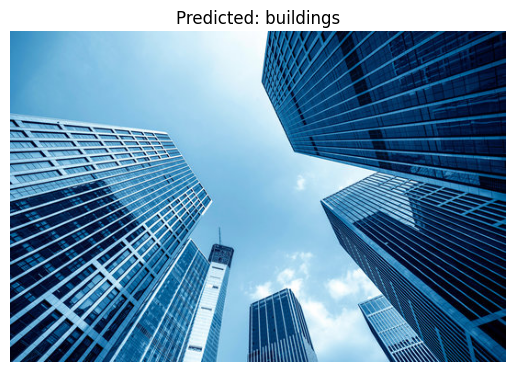

Prediksi: buildings


In [32]:
test_img_path = "gambar.jpg"
img, pred_class = predict_image(test_img_path)

plt.imshow(img)
plt.title(f"Predicted: {pred_class}")
plt.axis('off')
plt.show()

print("Prediksi:", pred_class)